In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

# New Section

In [ ]:
! pip install torchsummary

In [ ]:
! pip install einops

     |████████████████████████████████| 41 kB 275 kB/s eta 0:00:01


In [ ]:

labels_dataframe = pd.read_csv('../leaves data/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [ ]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/3120.jpg,maclura_pomifera
freq,1,353


In [ ]:
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = {v : k for k, v in class_to_num.items()}

In [ ]:

class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):

        
       
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        self.data_info = pd.read_csv(csv_path, header=None) 
        
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])
          
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        
        single_image_name = self.image_arr[index]

       
        img_as_img = Image.open(self.file_path + single_image_name)
        
     
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   
                transforms.ToTensor()
            ])
        else:
          
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
           
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  

    def __len__(self):
        return self.real_len


In [ ]:
train_path = '../leaves data/train.csv'
test_path = '../leaves data/test.csv'

img_path = '../leaves data/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [ ]:

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=64, 
        shuffle=False,
        num_workers=5
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=64, 
        shuffle=False,
        num_workers=5
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=64, 
        shuffle=False,
        num_workers=5
    )

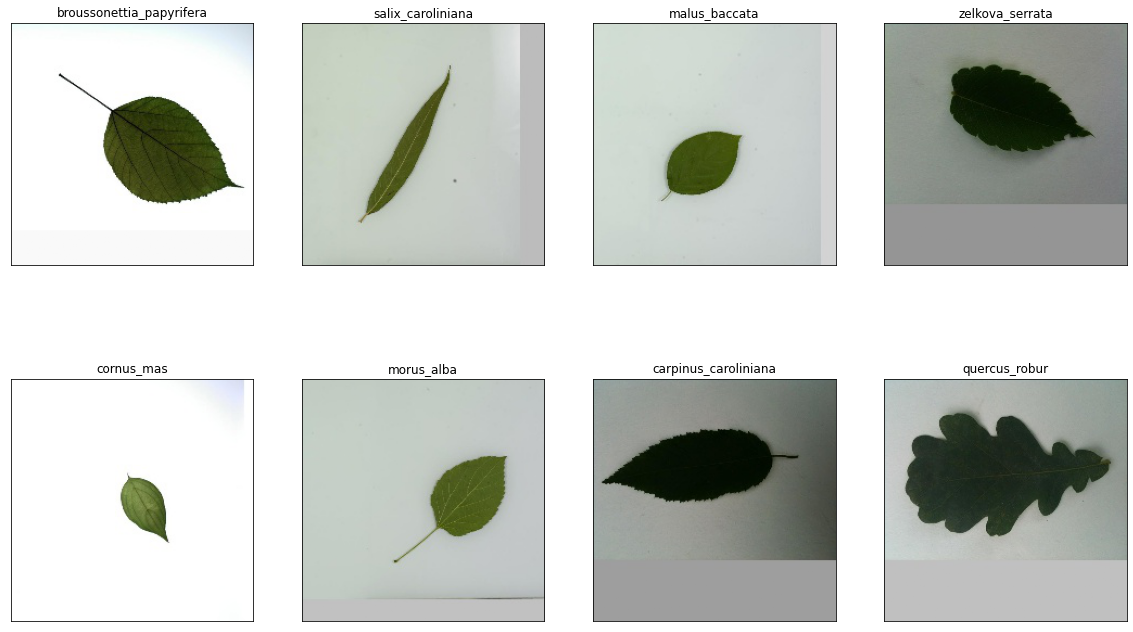

In [ ]:

def im_convert(tensor):

    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [ ]:

def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [ ]:

learning_rate =3e-4
weight_decay =1e-3
num_epoch = 50
path = '../'

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 176):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [ ]:

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 176,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
! pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=8de23af952ad16ce68cb303f755c087b7b81b0decdec3b0082b5988b56f2bf9f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
# try different efficientNet model
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b2')

In [ ]:

# Initialize a model, and put it on the device specified.
# model = ViT()
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
train_losses = []
valid_losses = []
train_accues = []
valid_accues = []



for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
       
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_accues.append(train_acc)
    train_losses.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_accues.append(valid_acc)
    valid_losses.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(),  '%s/model.pt' % (path))
        print('saving model with acc {:.3f}'.format(best_acc))

  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 4.89243, acc = 0.04386


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 001/050 ] loss = 5.93222, acc = 0.00754
saving model with acc 0.008


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 3.64699, acc = 0.12209


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 6.83747, acc = 0.00916
saving model with acc 0.009


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 3.10202, acc = 0.20338


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 4.36065, acc = 0.05550
saving model with acc 0.055


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 2.66189, acc = 0.28574


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 004/050 ] loss = 3.52968, acc = 0.14071
saving model with acc 0.141


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 2.27829, acc = 0.37133


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 005/050 ] loss = 3.26881, acc = 0.17744
saving model with acc 0.177


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 1.97969, acc = 0.44236


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 006/050 ] loss = 2.58808, acc = 0.30397
saving model with acc 0.304


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 1.72447, acc = 0.50136


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 007/050 ] loss = 2.42726, acc = 0.34914
saving model with acc 0.349


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 1.53011, acc = 0.56101


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 008/050 ] loss = 2.31772, acc = 0.36728
saving model with acc 0.367


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 1.34552, acc = 0.61028


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 009/050 ] loss = 2.09901, acc = 0.41065
saving model with acc 0.411


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 1.22794, acc = 0.64235


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 010/050 ] loss = 2.35825, acc = 0.36306


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 1.10086, acc = 0.67705


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 011/050 ] loss = 1.90033, acc = 0.47557
saving model with acc 0.476


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 1.00271, acc = 0.70749


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 2.03431, acc = 0.43005


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 0.91213, acc = 0.73144


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 013/050 ] loss = 1.69299, acc = 0.52038
saving model with acc 0.520


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 0.85979, acc = 0.74938


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 1.47855, acc = 0.57750
saving model with acc 0.577


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 0.78426, acc = 0.77024


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 015/050 ] loss = 1.50667, acc = 0.56376


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 0.73894, acc = 0.78773


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 1.47308, acc = 0.57947
saving model with acc 0.579


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 0.67999, acc = 0.80791


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 017/050 ] loss = 1.34612, acc = 0.60345
saving model with acc 0.603


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 0.63245, acc = 0.82007


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 018/050 ] loss = 1.31984, acc = 0.61297
saving model with acc 0.613


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 0.58500, acc = 0.83881


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 019/050 ] loss = 1.59162, acc = 0.55190


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 0.56121, acc = 0.84568


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 020/050 ] loss = 1.23630, acc = 0.63344
saving model with acc 0.633


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 0.51804, acc = 0.85669


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 021/050 ] loss = 1.18243, acc = 0.65499
saving model with acc 0.655


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 0.48943, acc = 0.86760


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 022/050 ] loss = 1.28630, acc = 0.63236


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 0.46285, acc = 0.87544


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 023/050 ] loss = 1.22816, acc = 0.64520


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 0.42808, acc = 0.88879


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 024/050 ] loss = 1.34129, acc = 0.63434


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 0.41769, acc = 0.89045


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 025/050 ] loss = 1.27309, acc = 0.64071


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 0.40321, acc = 0.89860


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 026/050 ] loss = 1.07294, acc = 0.69872
saving model with acc 0.699


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 0.37515, acc = 0.90655


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 027/050 ] loss = 1.17219, acc = 0.66236


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 0.36874, acc = 0.90693


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 028/050 ] loss = 1.13303, acc = 0.68391


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 0.35001, acc = 0.91178


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 029/050 ] loss = 1.52339, acc = 0.60650


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 0.33472, acc = 0.91658


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 030/050 ] loss = 1.12824, acc = 0.68148


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 0.32632, acc = 0.92201


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 031/050 ] loss = 1.22526, acc = 0.65374


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 0.33454, acc = 0.91450


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 032/050 ] loss = 1.22953, acc = 0.65329


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 0.31276, acc = 0.92663


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 033/050 ] loss = 1.25735, acc = 0.64781


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 0.29499, acc = 0.92917


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 034/050 ] loss = 1.02920, acc = 0.71202
saving model with acc 0.712


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 0.28236, acc = 0.93424


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 035/050 ] loss = 1.13731, acc = 0.68939


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 0.27468, acc = 0.93675


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 036/050 ] loss = 1.33232, acc = 0.63515


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 0.29019, acc = 0.93132


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 037/050 ] loss = 1.10225, acc = 0.68831


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 0.26734, acc = 0.93875


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 038/050 ] loss = 1.04800, acc = 0.70528


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 0.26212, acc = 0.93981


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 039/050 ] loss = 1.11146, acc = 0.69486


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 0.25272, acc = 0.94287


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 040/050 ] loss = 1.05425, acc = 0.70546


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 0.24691, acc = 0.94341


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 041/050 ] loss = 1.54807, acc = 0.61575


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 0.24511, acc = 0.94623


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 042/050 ] loss = 1.25708, acc = 0.66298


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 0.23891, acc = 0.94633


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 043/050 ] loss = 1.02618, acc = 0.71264
saving model with acc 0.713


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 0.23289, acc = 0.94912


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 044/050 ] loss = 1.42105, acc = 0.63111


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 0.23136, acc = 0.94905


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 045/050 ] loss = 1.08012, acc = 0.70995


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 0.24750, acc = 0.94069


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 046/050 ] loss = 1.07611, acc = 0.70932


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 0.22300, acc = 0.95088


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 047/050 ] loss = 1.70250, acc = 0.59501


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 0.21703, acc = 0.95292


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 048/050 ] loss = 1.12627, acc = 0.69406


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 0.21863, acc = 0.95275


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 049/050 ] loss = 1.53160, acc = 0.61512


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 0.21372, acc = 0.95428


100%|██████████| 58/58 [00:13<00:00,  4.18it/s]


[ Valid | 050/050 ] loss = 0.98461, acc = 0.72908
saving model with acc 0.729


In [ ]:
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [ ]:
# resnext50

def resnext_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [ ]:
model = resnext_model(176)

In [ ]:
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

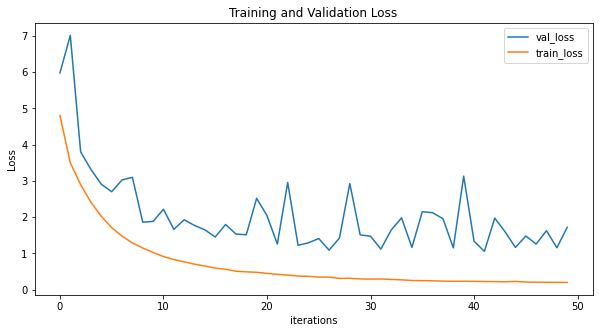

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(valid_losses,label="val_loss")
plt.plot(train_losses,label="train_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

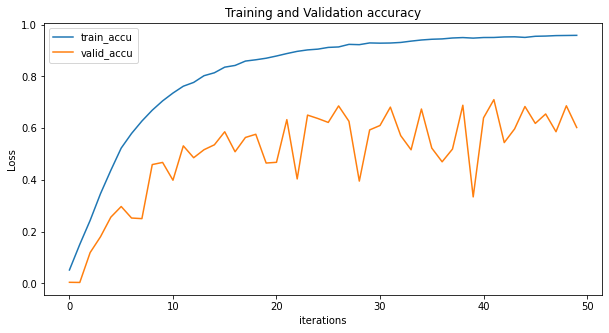

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(train_accues,label="train_accu")
plt.plot(valid_accues,label="valid_accu")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#testing
# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)

In [ ]:
model = ViT()
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
train_losses = []
valid_losses = []
train_accues = []
valid_accues = []



for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
       
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_accues.append(train_acc)
    train_losses.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_accues.append(valid_acc)
    valid_losses.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(),  '%s/model.pt' % (path))
        print('saving model with acc {:.3f}'.format(best_acc))

  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 5.25862, acc = 0.01261


100%|██████████| 58/58 [00:23<00:00,  2.48it/s]


[ Valid | 001/050 ] loss = 5.22714, acc = 0.00943


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.009


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 5.15881, acc = 0.01390


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 5.20620, acc = 0.00943


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 5.13824, acc = 0.01498


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 5.19644, acc = 0.00943


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 5.11220, acc = 0.01614


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 004/050 ] loss = 5.16955, acc = 0.01131


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.011


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 5.07705, acc = 0.01821


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 005/050 ] loss = 5.14435, acc = 0.01239


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.012


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 5.05644, acc = 0.01773


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 006/050 ] loss = 5.13231, acc = 0.01455


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.015


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 5.04127, acc = 0.01963


100%|██████████| 58/58 [00:23<00:00,  2.47it/s]


[ Valid | 007/050 ] loss = 5.09228, acc = 0.01643


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.016


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 4.90357, acc = 0.02371


100%|██████████| 58/58 [00:23<00:00,  2.49it/s]


[ Valid | 008/050 ] loss = 4.72896, acc = 0.02074


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.021


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 4.61382, acc = 0.02969


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 009/050 ] loss = 4.63726, acc = 0.02532


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.025


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 4.48827, acc = 0.03716


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 010/050 ] loss = 4.56239, acc = 0.03556


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.036


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 4.44685, acc = 0.04063


100%|██████████| 58/58 [00:23<00:00,  2.51it/s]


[ Valid | 011/050 ] loss = 4.50791, acc = 0.04364


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.044


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 4.39066, acc = 0.04532


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 4.48163, acc = 0.04256


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 4.34878, acc = 0.04620


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 013/050 ] loss = 4.43459, acc = 0.04472


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.045


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 4.27087, acc = 0.05263


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 4.37388, acc = 0.04445


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 4.20047, acc = 0.05932


100%|██████████| 58/58 [00:23<00:00,  2.50it/s]


[ Valid | 015/050 ] loss = 4.30937, acc = 0.05307


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.053


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 4.16290, acc = 0.06160


  0%|          | 0/230 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 4.28601, acc = 0.05172


  0%|          | 0/58 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 4.14855, acc = 0.06442


100%|██████████| 58/58 [00:23<00:00,  2.49it/s]


[ Valid | 017/050 ] loss = 4.27074, acc = 0.05460


  0%|          | 0/230 [00:00<?, ?it/s]

saving model with acc 0.055


 14%|█▍        | 32/230 [00:37<03:51,  1.17s/it]


KeyboardInterrupt: 